# Explain the problem and how you tackle it here

The problem of image superresolution is concerned with taking a low resolution image and then convert it to a high resolution image only using the LR image. This notebook uses SRGAN which is a generative adversarial network that is created for image superresolution. One of the reasons I chose to tackle this problem is because it is an interesting problem that can give someone a lot of insights.

In [73]:
!pip install -r requirements.txt

import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import random
import torch.nn as nn
from torchvision.models import vgg19
import torch
from torch import optim
from tqdm.notebook import tqdm
import torchvision.transforms as transforms

#### First of all, the dataset can't be loaded using generic datasets as we need it to be in a specific way (low resolution image[i], high resolution image[i])
#### Since the data is large and can't fit in memory directory we will use dataloaders on our dataset

In [74]:
# Define the transformations on the data
low_res_size = 128
high_res_size = 256

transform_low = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((low_res_size, low_res_size)),
    transforms.ToTensor(),
])

transform_high = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((high_res_size, high_res_size)),
    transforms.ToTensor(),
])

In [75]:
class ImageDataset(Dataset):
    # This is a custom dataset created using pytorch Dataset
    def __init__(self, root_dir):
        super(ImageDataset, self).__init__()
        self.data = []
        self.root_dir = root_dir
        files_low = os.listdir(os.path.join(root_dir, "low_res"))
        files_high = os.listdir(os.path.join(root_dir, "high_res"))
    
        files_low.sort()
        files_high.sort()

        print(files_high)

        self.data = list(zip(files_low, files_high))

        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_low_file, img_high_file = self.data[index]
        
        # Get the path for the image LR and HR
        low_res_pth = os.path.join(self.root_dir, "low_res", img_low_file)
        high_res_pth = os.path.join(self.root_dir, "high_res", img_high_file)

        # Open the actual image in order of name
        low_res = np.array(Image.open(low_res_pth))
        high_res = np.array(Image.open(high_res_pth))
        
        # Discarding the alpha channel to make the model more optimized for memory
        low_res = low_res[:, :, :3]
        high_res = high_res[:, :, :3]
        
        # Apply the transformation to the image
        low_res = transform_low(low_res)
        high_res = transform_high(high_res)
        
        return low_res, high_res


In [76]:
# Showing an image from the dataset
def show_image(root_dir: str):
    dataset = ImageDataset(root_dir=root_dir)
    loader = DataLoader(dataset, batch_size=128, num_workers=4)
    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    for idx, (low_res, high_res) in enumerate(loader):
        # Display the first image in the left subplot
        axs[0].imshow(low_res[0].permute(1, 2, 0))
        axs[0].set_title("low res")

        # Display the second image in the right subplot
        axs[1].imshow(high_res[0].permute(1, 2, 0))
        axs[1].set_title("high res")
        
        if(idx == 0):
            break
            
    # Show the figure
    plt.show()           


['1.png', '10.png', '11.png', '12.png', '13.png', '14.png', '15-mega.png', '15.png', '16.png', '17.png', '18-mega.png', '18.png', '19.png', '2.png', '20.png', '21.png', '22.png', '23.png', '24.png', '25-belle.png', '25-libre.png', '25-phd.png', '25-pop-star.png', '25-rock-star.png', '25.png', '26.png', '27.png', '28.png', '29.png', '3-mega.png', '3.png', '30.png', '31.png', '32.png', '33.png', '34.png', '35.png', '36.png', '37.png', '38.png', '39.png', '4.png', '40.png', '41.png', '42.png', '43.png', '44.png', '45.png', '46.png', '47.png', '48.png', '49.png', '5.png', '50.png', '51.png', '52.png', '53.png', '54.png', '55.png', '56.png', '57.png', '58.png', '59.png', '6-mega-x.png', '6-mega-y.png', '6.png', '60.png', '61.png', '62.png', '63.png', '64.png', '65-mega.png', '65.png', '66.png', '67.png', '68.png', '69.png', '7.png', '70.png', '71.png', '72.png', '73.png', '74.png', '75.png', '76.png', '77.png', '78.png', '79.png', '8.png', '80-mega.png', '80.png', '81.png', '82.png', '83.pn

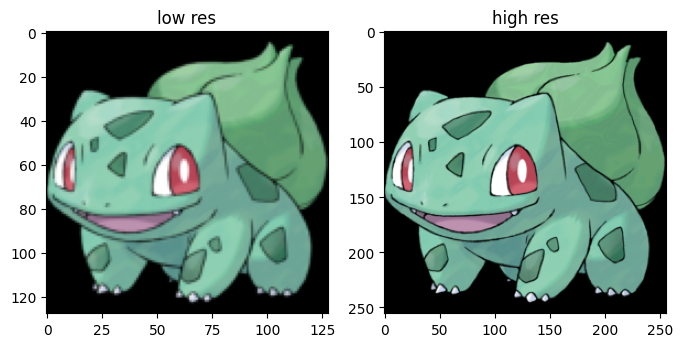

['100.png', '101.png', '102.png', '103.png', '104.png', '105.png', '106.png', '107.png', '108.png', '109.png', '110.png', '111.png', '112.png', '113.png', '114.png', '115-mega.png', '115.png', '116.png', '117.png', '118.png', '119.png', '120.png', '121.png', '122.png', '123.png', '124.png', '125.png', '126.png', '127-mega.png', '127.png', '128.png', '129.png', '130-mega.png', '130.png', '131.png', '132.png', '133.png', '134.png', '135.png', '136.png', '137.png', '138.png', '139.png', '140.png', '141.png', '142-mega.png', '142.png', '143.png', '144.png', '145.png', '146.png', '147.png', '148.png', '149.png', '150-mega-x.png', '150-mega-y.png', '150.png', '151.png']


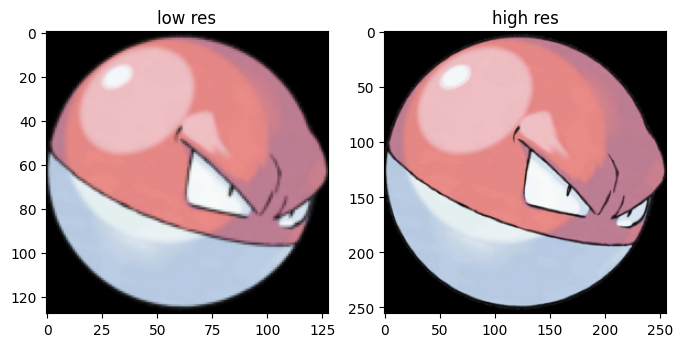

In [77]:
train_root_dir: str = 'resources/pokemon/sugimori/train'
val_root_dir: str = 'resources/pokemon/sugimori/val'

show_image(train_root_dir)
show_image(val_root_dir)

#### define the hyperparameters

In [78]:
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 3e-4
epochs = 60
batch_size = 16
num_workers = 2
img_channels = 3

The architecture uses two losses: The normal BCE loss for GANs to create the adversarial loss, and the VGG loss which acts as a perceptual loss for the features. The usual losses try to average the loss so the images in the end are given in a blurry way. However, the VGG loss tries to minimize the difference in perceptual features which gives a kind of a sharper image.

In [79]:
# listing the model to take the required subset of it
test_vgg_model = vgg19(weights=True).eval().to(device)
lf = list(test_vgg_model.features)
lf[25]

/home/mabazin/miniconda3/envs/tf/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [80]:
class vggL(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg = vgg19(pretrained=True).features[:25].eval().to(device)
        self.loss = nn.MSELoss()

    def forward(self, first, second):
        vgg_first = self.vgg(first)
        vgg_second = self.vgg(second)
        perceptual_loss = self.loss(vgg_first, vgg_second)
        return perceptual_loss

### The architecture follows the original paper's implementation with some minor changes

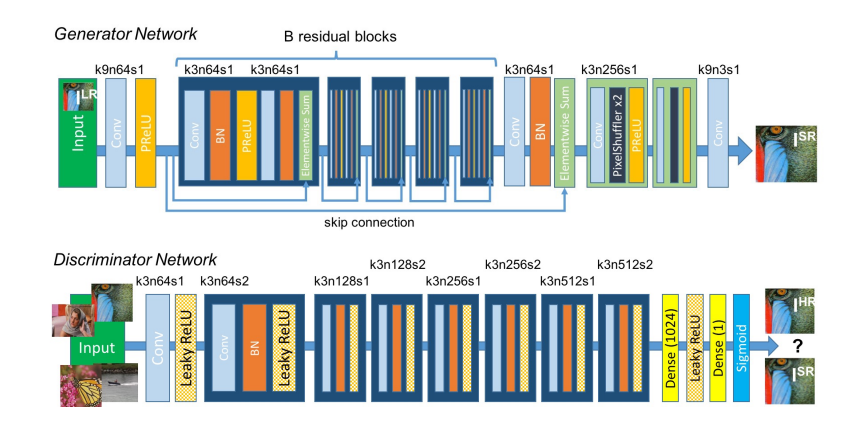

In [81]:
class ConvBlock(nn.Module):
    # Conv -> BN -> leakyReLU
    def __init__(
            self,
            in_channels,
            out_channels,
            use_activation=True,
            use_BatchNorm=True,
            **kwargs
    ):
        
        super().__init__()
        self.use_activation = use_activation
        self.cnn = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels) if use_BatchNorm else nn.Identity()
        self.ac = (
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x):
        x1 = self.cnn(x)
        x2 = self.bn(x1)
        x3 = self.ac(x2)
        return x3 if self.use_activation else x2

In [82]:
class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, scale_factor):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, in_channels * scale_factor ** 2, 2, 1, 1)
        self.ps = nn.PixelShuffle(scale_factor)
        self.ac = nn.PReLU(num_parameters=in_channels)

    def forward(self, x):
        return self.ac(self.ps(self.conv(x)))

In [83]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.b1 = ConvBlock(
            in_channels,
            in_channels,
            kernel_size=3,
            stride=1,
            padding=1
        )

        self.b2 = ConvBlock(
            in_channels,
            in_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            use_activation=False
        )

    def forward(self, x):
        out = self.b1(x)
        out = self.b2(out)
        return out + x

In [84]:
class Generator(nn.Module):
    def __init__(self, in_channels=3, num_channels=64, num_blocks=8):
        super().__init__()
        self.initial = ConvBlock(in_channels, num_channels, kernel_size=7, stride=1, padding=4, use_BatchNorm=False)
        self.res = nn.Sequential(*[ResidualBlock(num_channels) for i in range(num_blocks)])
        self.conv = ConvBlock(num_channels, num_channels, kernel_size=3, stride=1, padding=1, use_activation=False)
        self.up = nn.Sequential(UpsampleBlock(num_channels, scale_factor=2)) 
        self.final = nn.Conv2d(num_channels, in_channels, kernel_size=9, stride=1, padding=1)

    def forward(self, x):
        x = self.initial(x)
        c = self.res(x)
        c = self.conv(c) + x
        c = self.up(c)
        return torch.sigmoid(self.final(c))

In [85]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 64, 128, 128, 256, 256, 512, 512]):
        super().__init__()
        blocks = []
        for idx, feature in enumerate(features):
            blocks.append(
                ConvBlock(
                    in_channels,
                    feature,
                    kernel_size=3,
                    stride = idx % 2 + 1,
                    padding=1,
                    use_activation=True,
                    use_BatchNorm=idx != 0,
                )
            )
            in_channels = feature

        self.blocks = nn.Sequential(*blocks)

        self.mlp = nn.Sequential(
            nn.AdaptiveAvgPool2d((8, 8)),
            nn.Flatten(),
            nn.Linear(512*8*8, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1)
        )

    def forward(self, x):
        x = self.blocks(x)
        x = self.mlp(x)
        return x

# helper functions

In [86]:
def plot_examples(gen, root_dir: str):
    dataset_test = ImageDataset(root_dir)
    loader = DataLoader(dataset_test, batch_size=16, num_workers=2)
    
    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 3, figsize=(8, 4))
    chosen_batch = random.randint(0, len(loader)-1)
    for idx, (low_res, high_res) in enumerate(loader):
        if(chosen_batch == idx):
            chosen = random.randint(0, len(low_res)-1)
        
            axs[0].set_axis_off()
            axs[0].imshow(low_res[chosen].permute(1, 2, 0))
            axs[0].set_title("low res")

            with torch.no_grad():
                upscaled_img = gen(low_res[chosen].to(device).unsqueeze(0))
        
            axs[1].set_axis_off()
            axs[1].imshow(upscaled_img.cpu().permute(0, 2, 3, 1)[0])
            axs[1].set_title("predicted")
        
            axs[2].set_axis_off()
            axs[2].imshow(high_res[chosen].permute(1, 2, 0))
            axs[2].set_title("high res")
        
            if(idx == 1):
                break
            
    # Show the figure
    plt.show()      
    
    gen.train()

In [87]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

def train_progress(epoch, num_epochs, d_losses, g_losses):
    clear_output(wait=True)
    plt.figure(figsize=(10,5))
    plt.title("Training progress")
    plt.plot(d_losses,label="Discriminator loss")
    plt.plot(g_losses,label="Generator loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    print(f"Epoch [{epoch}/{num_epochs}], Discriminator loss: {d_losses[-1]:.4f}, Generator loss: {g_losses[-1]:.4f}")

# the training loop

In [88]:
# define the generator / discriminator / and other hyperparameters (not already defined above)
gen = Generator(in_channels=3).to(device)
disc = Discriminator(in_channels=3).to(device)
opt_gen = optim.Adam(gen.parameters(), lr=lr, betas=(0.9, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=lr, betas=(0.9, 0.999))
mse = nn.MSELoss()
bce = nn.BCEWithLogitsLoss()
vgg_loss = vggL()

/home/mabazin/miniconda3/envs/tf/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(


In [89]:
# the data loaders for training and validation

train = ImageDataset(root_dir=train_root_dir)
train_loader = DataLoader(train, batch_size=batch_size, num_workers=num_workers)

val = ImageDataset(root_dir=val_root_dir)
val_loader = DataLoader(val, batch_size=batch_size, num_workers=num_workers)

['1.png', '10.png', '11.png', '12.png', '13.png', '14.png', '15-mega.png', '15.png', '16.png', '17.png', '18-mega.png', '18.png', '19.png', '2.png', '20.png', '21.png', '22.png', '23.png', '24.png', '25-belle.png', '25-libre.png', '25-phd.png', '25-pop-star.png', '25-rock-star.png', '25.png', '26.png', '27.png', '28.png', '29.png', '3-mega.png', '3.png', '30.png', '31.png', '32.png', '33.png', '34.png', '35.png', '36.png', '37.png', '38.png', '39.png', '4.png', '40.png', '41.png', '42.png', '43.png', '44.png', '45.png', '46.png', '47.png', '48.png', '49.png', '5.png', '50.png', '51.png', '52.png', '53.png', '54.png', '55.png', '56.png', '57.png', '58.png', '59.png', '6-mega-x.png', '6-mega-y.png', '6.png', '60.png', '61.png', '62.png', '63.png', '64.png', '65-mega.png', '65.png', '66.png', '67.png', '68.png', '69.png', '7.png', '70.png', '71.png', '72.png', '73.png', '74.png', '75.png', '76.png', '77.png', '78.png', '79.png', '8.png', '80-mega.png', '80.png', '81.png', '82.png', '83.pn

In [90]:
def train_fn(loader, disc, gen, opt_gen, opt_disc, mse, bce, vgg_loss):
    #loop = tqdm(train_loader)
    disc_loss = 0
    gen_loss = 0

    for idx, (low_res, high_res) in enumerate(train_loader):
        high_res = high_res.to(device)
        low_res = low_res.to(device)
        
        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        #print("D")
        fake = gen(low_res)
        
        disc_real = disc(high_res)
        disc_fake = disc(fake.detach())
        
        disc_loss_real = bce(disc_real, torch.ones_like(disc_real))
        disc_loss_fake = bce(disc_fake, torch.zeros_like(disc_fake))
        
        disc_loss = disc_loss_fake + disc_loss_real

        opt_disc.zero_grad()
        disc_loss.backward()
        opt_disc.step()

        # Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        disc_fake = disc(fake)
        adversarial_loss = 1e-3 * bce(disc_fake, torch.ones_like(disc_fake))
        loss_for_vgg = 0.006 * vgg_loss(fake, high_res)
        gen_loss = loss_for_vgg + adversarial_loss

        opt_gen.zero_grad()
        gen_loss.backward()
        opt_gen.step()

            
    return gen_loss.detach().cpu(), disc_loss.detach().cpu()

# Device usage

In [91]:
device_count = torch.cuda.device_count()
if device_count > 0:
    for i in range(device_count):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPUs available.")

forceSelectCPU = False

if torch.cuda.is_available() and not forceSelectCPU:
    device = torch.device('cuda:0')
    import gc
    torch.cuda.empty_cache()
    gc.collect()

    print(torch.cuda.memory_summary(device=device, abbreviated=True))

    print("Select gpu 0")
else:
    device = torch.device('cpu')
    print("Select cpu")


GPU 0: NVIDIA GeForce RTX 3060
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   1459 MiB |   8712 MiB |  12451 GiB |  12450 GiB |
|---------------------------------------------------------------------------|
| Active memory         |   1459 MiB |   8712 MiB |  12451 GiB |  12450 GiB |
|---------------------------------------------------------------------------|
| Requested memory      |   1446 MiB |   8700 MiB |  12444 GiB |  12443 GiB |
|--------------------------------

In [92]:
def predict(gen, low_res):
    num_samples = len(low_res) # batch size
    upscaled_images = np.zeros((num_samples, 3, high_res_size, high_res_size), dtype=np.float32)

    with torch.no_grad():
        for i in range(num_samples):
            upscaled_images[i] = gen(low_res[i].to(device).unsqueeze(0)).cpu()[0]

    return upscaled_images

In [96]:
from metrics import Metric
from skimage.metrics import peak_signal_noise_ratio

d_losses = []
g_losses = []
PSNRs = []
SSIMs = []

# Print the size of the futur model
print(f"Number of parameters in generator: {sum(p.numel() for p in gen.parameters())}")
# Size in megabytes
print(f"Size of generator: {sum(p.numel() for p in gen.parameters()) * 4 / 1000000} MB")

for epoch in range(epochs):
     #plot_examples(gen, val_root_dir)
     print("epoch ", epoch+1, "/", epochs)
     gen_loss, disc_loss = train_fn(train_loader, disc, gen, opt_gen, opt_disc, mse, bce, vgg_loss)
     # train discriminator and generator and update losses
     d_losses.append(disc_loss)
     g_losses.append(gen_loss)
     
     batch_PSRNs = []
     batch_SSIMs = []
     
     for (low_res, high_res) in train_loader:
          psnr, ssim = 0, 0

          res = predict(gen, low_res)
          
          for _high_res, _res in zip(high_res, res):
               _high_res = _high_res.detach().numpy()

               psnr += peak_signal_noise_ratio(_res, _high_res)
               ssim += Metric.SSIM(_res, _high_res)
          
          batch_PSRNs.append(psnr/len(low_res))
          batch_SSIMs.append(ssim/len(low_res))

     PSNRs.append(np.mean(batch_PSRNs))
     SSIMs.append(np.mean(batch_SSIMs))

     print(f'Disc loss : {d_losses[-1]} | Gen loss : {g_losses[-1]} | PSNR : {PSNRs[-1]} | SSIM : {SSIMs[-1]}')

Number of parameters in generator: 720835
Size of generator: 2.88334 MB
epoch  1 / 60
Disc loss : 4.352923393249512 | Gen loss : 0.011877295561134815 | PSNR : 10.694158429080831 | SSIM : 0.9976771256504765
epoch  2 / 60
Disc loss : 0.06509877741336823 | Gen loss : 0.034564901143312454 | PSNR : 7.79371317273703 | SSIM : 0.9939952157920939
epoch  3 / 60
Disc loss : 1.1920858923986088e-05 | Gen loss : 0.02628648653626442 | PSNR : 11.851180581759879 | SSIM : 0.9976634606311509
epoch  4 / 60
Disc loss : 13.575993537902832 | Gen loss : 0.011703019961714745 | PSNR : 10.846770009071005 | SSIM : 0.997328656571061
epoch  5 / 60
Disc loss : 11.99440860748291 | Gen loss : 0.011435548774898052 | PSNR : 11.232907117257486 | SSIM : 0.9974460160593943
epoch  6 / 60


KeyboardInterrupt: 

tensor(0.9882)
tensor(1.)
tensor(0.9961)
tensor(0.9765)
tensor(0.9725)
tensor(0.9569)
tensor(0.9765)
tensor(0.9843)
tensor(0.9804)
tensor(1.)
tensor(0.9843)
tensor(0.9922)
tensor(0.9725)
tensor(0.9725)
tensor(1.)
tensor(0.9922)


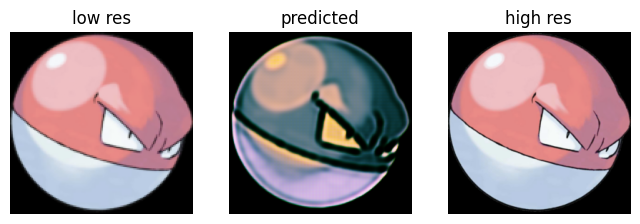

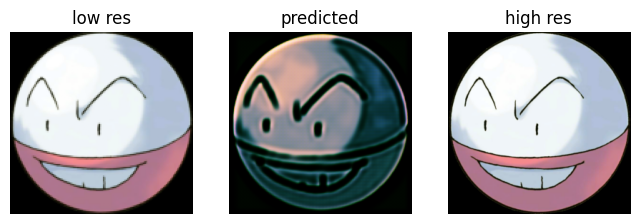

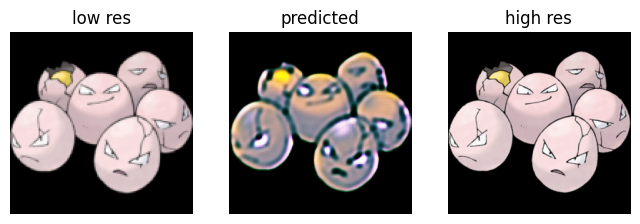

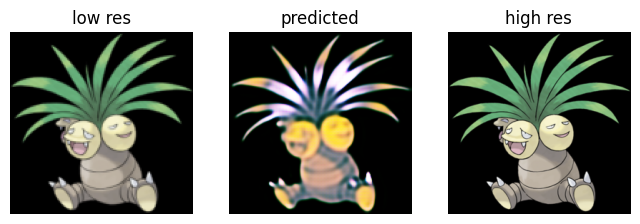

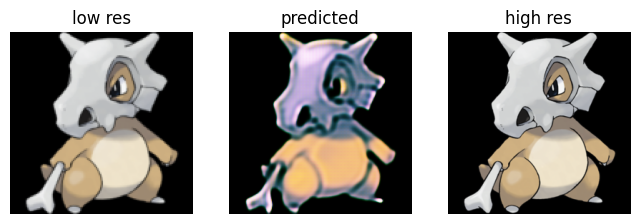

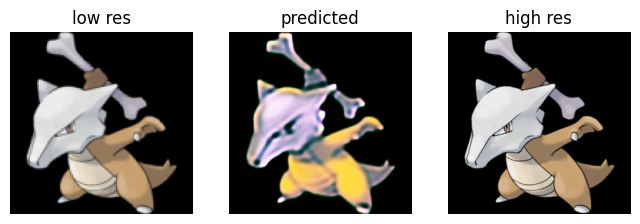

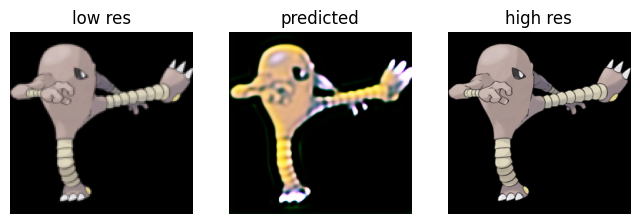

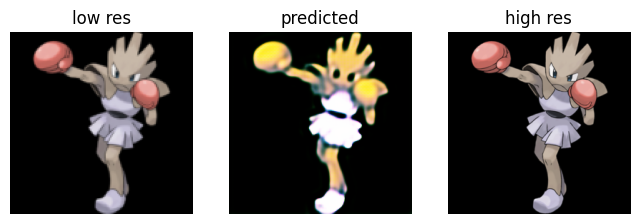

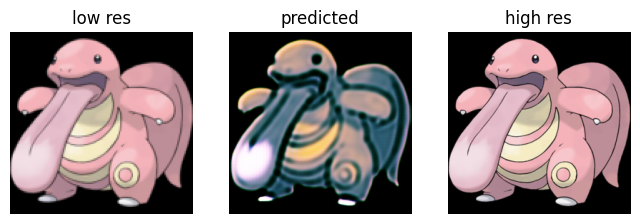

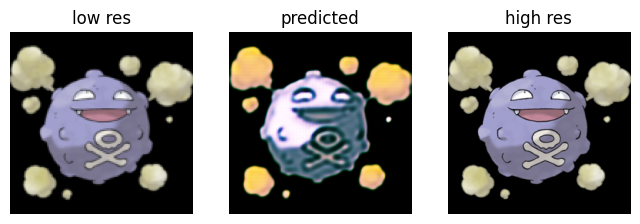

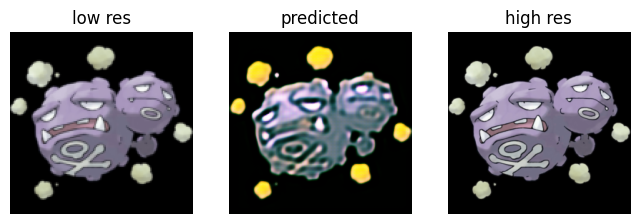

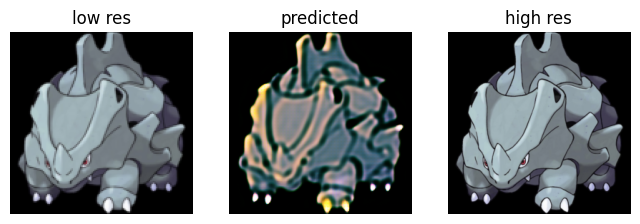

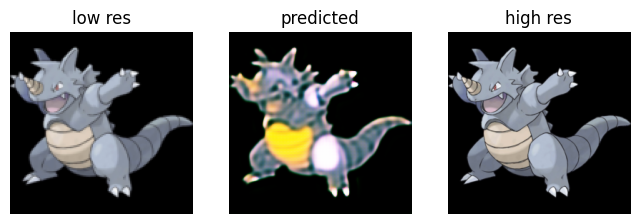

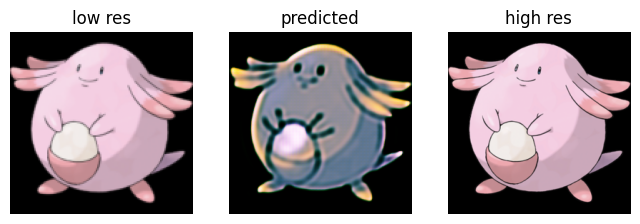

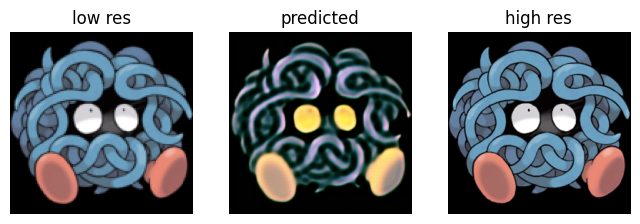

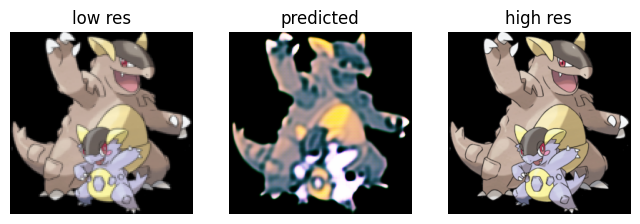

In [ ]:
for (low_res, high_res) in val_loader:
    res = predict(gen, low_res)
    
    for _low_res, _high_res, _res in zip(low_res, high_res, res):
        fig, axs = plt.subplots(1, 3, figsize=(8, 4))

        axs[0].set_axis_off()
        axs[0].imshow(_low_res.permute(1, 2, 0), vmin=0, vmax=1)
        axs[0].set_title("low res")
        
        axs[1].set_axis_off()
        axs[1].imshow(np.transpose(_res ,(1, 2, 0)), vmin=0, vmax=1)
        axs[1].set_title("predicted")
    
        axs[2].set_axis_off()
        axs[2].imshow(_high_res.permute(1, 2, 0), vmin=0, vmax=1)
        axs[2].set_title("high res")
    break

['100.png', '101.png', '102.png', '103.png', '104.png', '105.png', '106.png', '107.png', '108.png', '109.png', '110.png', '111.png', '112.png', '113.png', '114.png', '115-mega.png', '115.png', '116.png', '117.png', '118.png', '119.png', '120.png', '121.png', '122.png', '123.png', '124.png', '125.png', '126.png', '127-mega.png', '127.png', '128.png', '129.png', '130-mega.png', '130.png', '131.png', '132.png', '133.png', '134.png', '135.png', '136.png', '137.png', '138.png', '139.png', '140.png', '141.png', '142-mega.png', '142.png', '143.png', '144.png', '145.png', '146.png', '147.png', '148.png', '149.png', '150-mega-x.png', '150-mega-y.png', '150.png', '151.png']


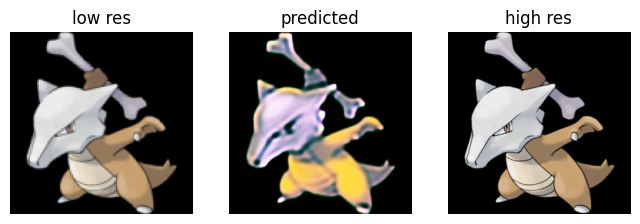

In [ ]:
# print progress
plot_examples(gen, val_root_dir)
#train_progress(epoch, epochs, d_losses, g_losses)

# Save the model

In [ ]:
torch.save(gen.state_dict(), "weights/checkpoint1_gen")
torch.save(disc.state_dict(), "weights/checkpoint1_disc")

# References:
<ul>
    <li>https://arxiv.org/abs/1609.04802
    <li>https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master/ML/Pytorch/GANs/SRGAN
    <li>https://www.geeksforgeeks.org/super-resolution-gan-srgan/
    <li>and of course a lot of stackoverflow, and pytorch docs
</ul>

#### Add validation metrics using PSNR, SSIM, and MSE on training

['100.png', '101.png', '102.png', '103.png', '104.png', '105.png', '106.png', '107.png', '108.png', '109.png', '110.png', '111.png', '112.png', '113.png', '114.png', '115-mega.png', '115.png', '116.png', '117.png', '118.png', '119.png', '120.png', '121.png', '122.png', '123.png', '124.png', '125.png', '126.png', '127-mega.png', '127.png', '128.png', '129.png', '130-mega.png', '130.png', '131.png', '132.png', '133.png', '134.png', '135.png', '136.png', '137.png', '138.png', '139.png', '140.png', '141.png', '142-mega.png', '142.png', '143.png', '144.png', '145.png', '146.png', '147.png', '148.png', '149.png', '150-mega-x.png', '150-mega-y.png', '150.png', '151.png']
torch.Size([256, 256, 3])
torch.Size([256, 256, 3])
MSE : 0.1851948362400374 | SKImage MSE : 0.18519483623227675
PSNR : 55.45451487721359 | SKimage PSNR : 7.3237112687164805
SSIM : 0.9959464443738071 | SKimage SSIM : 0.975809362988472


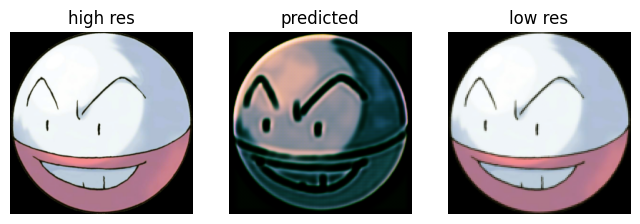

In [ ]:
validation_dataset = ImageDataset(root_dir=val_root_dir)
validation_loader = DataLoader(validation_dataset, batch_size=128, num_workers=4)

image_to_show = 1

for _, (low_res, high_res) in enumerate(validation_loader):
    for idx in range(len(low_res)):
        if image_to_show != idx:
            continue
        
        # Get an image in train set
        image1 = high_res[idx].permute(1, 2, 0)
        print(image1.shape)

        # gen a fake image from the same image
        image2 = gen(low_res[idx].unsqueeze(0).to(device)).cpu().permute(0, 2, 3, 1)[0]
        print(image2.shape)

        # convert tensor image to numpy array
        image1 = image1.detach().numpy()
        image2 = image2.detach().numpy()

        """from damage_image import Damager
        image2 = Damager().add_salt_and_pepper_noise(image2, 0.001, 0.001)"""

        print(f"MSE : {Metric.MSE(image1, image2)} | SKImage MSE : {mean_squared_error(image1, image2)}")
        print(f"PSNR : {Metric.PSNR(image1, image2)} | SKimage PSNR : {peak_signal_noise_ratio(image1, image2)}")
        print(f"SSIM : {Metric.SSIM(image1, image2)} | SKimage SSIM : {Metric.SSIM_ref(image1, image2)}")

        # Plot the hight res, the low res and the fake image

        fig, axs = plt.subplots(1, 3, figsize=(8, 4))
        axs[0].set_axis_off()
        axs[0].imshow(image1, vmin=0, vmax=1)
        axs[0].set_title("high res")

        axs[1].set_axis_off()
        axs[1].imshow(image2, vmin=0, vmax=1)
        axs[1].set_title("predicted")

        axs[2].set_axis_off()
        axs[2].imshow(low_res[idx].permute(1, 2, 0), vmin=0, vmax=1)
        axs[2].set_title("low res")

        plt.show()

# Compute the mean PSNR and SSIM

In [ ]:
# Compute the mean PSNR and SSIM
def mean_psnr_ssim(dataset, loader):
    psnr = 0
    ssim = 0

    for _, (low_res, high_res) in enumerate(loader):
        for idx in range(len(low_res)):
            # Get an image in train set
            image1 = high_res[idx].permute(1, 2, 0)

            # gen a fake image from the same image
            image2 = gen(low_res[idx].unsqueeze(0).to(device)).cpu().permute(0, 2, 3, 1)[0]

            # convert tensor image to numpy array
            image1 = image1.detach().numpy()
            image2 = image2.detach().numpy()

            psnr += peak_signal_noise_ratio(image1, image2)
            ssim += Metric.SSIM_ref(image1, image2)

            # Show advancement
            if(idx % (len(low_res) // 5) == 0):
                print(f"{idx / len(low_res) * 100} %")

    return psnr / len(low_res), ssim / len(low_res)

# Training set
training_dataset = ImageDataset(root_dir=train_root_dir)
training_loader = DataLoader(training_dataset, batch_size=128, num_workers=4)

training_mean_psnr, training_mean_ssim = mean_psnr_ssim(training_dataset, training_loader)

print(f"Mean training PSNR : {training_mean_psnr}") 
print(f"Mean training SSIM : {training_mean_ssim}")

# Validation set

validation_mean_psnr, validation_mean_ssim = mean_psnr_ssim(validation_dataset, validation_loader)

print(f"Mean validation PSNR : {validation_mean_psnr}")
print(f"Mean validation SSIM : {validation_mean_ssim}")

['1.png', '10.png', '11.png', '12.png', '13.png', '14.png', '15-mega.png', '15.png', '16.png', '17.png', '18-mega.png', '18.png', '19.png', '2.png', '20.png', '21.png', '22.png', '23.png', '24.png', '25-belle.png', '25-libre.png', '25-phd.png', '25-pop-star.png', '25-rock-star.png', '25.png', '26.png', '27.png', '28.png', '29.png', '3-mega.png', '3.png', '30.png', '31.png', '32.png', '33.png', '34.png', '35.png', '36.png', '37.png', '38.png', '39.png', '4.png', '40.png', '41.png', '42.png', '43.png', '44.png', '45.png', '46.png', '47.png', '48.png', '49.png', '5.png', '50.png', '51.png', '52.png', '53.png', '54.png', '55.png', '56.png', '57.png', '58.png', '59.png', '6-mega-x.png', '6-mega-y.png', '6.png', '60.png', '61.png', '62.png', '63.png', '64.png', '65-mega.png', '65.png', '66.png', '67.png', '68.png', '69.png', '7.png', '70.png', '71.png', '72.png', '73.png', '74.png', '75.png', '76.png', '77.png', '78.png', '79.png', '8.png', '80-mega.png', '80.png', '81.png', '82.png', '83.pn

MSE : 22276.038528442383 | SKImage MSE : 22276.038528442383
PSNR : 4.6524240049758285 | SKImage PSNR : 4.089578415259478
SSIM : 0.0002885509169874342 | SKimage SSIM : 0.10626934213681909


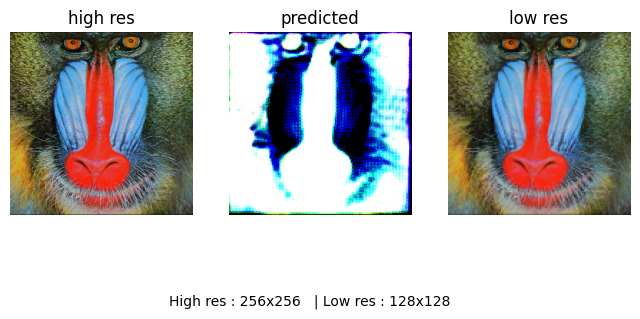

In [ ]:
# open a image from resources folder with cv2
# open it with a size of 256x256
# then reduce the size to 128x128

image = cv2.imread("resources/set14/baboon.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (256, 256))

low_image = cv2.resize(image, (128, 128))

low_image_torch = torch.tensor(low_image).permute(2, 0, 1).unsqueeze(0).float().to(device)

# Create an upscale version of the image via the model

upscaled_image = gen(low_image_torch).cpu().permute(0, 2, 3, 1)[0]

# Convert the image to numpy array

upscaled_image = upscaled_image.detach().numpy()

image1 = image
image2 = (upscaled_image * 255).astype(np.uint8)

print(f"MSE : {Metric.MSE(image1, image2)} | SKImage MSE : {mean_squared_error(image1, image2)}")
print(f"PSNR : {Metric.PSNR(image1, image2)} | SKImage PSNR : {peak_signal_noise_ratio(image1, image2, data_range=image1.max()-image1.min())}")
print(f"SSIM : {Metric.SSIM(image1, image2)} | SKimage SSIM : {Metric.SSIM_ref(image1, image2)}")

# Plot the hight res, the low res and the fake image

fig, axs = plt.subplots(1, 3, figsize=(8, 4))
axs[0].set_axis_off()
axs[0].imshow(image1, vmin=0, vmax=1)
axs[0].set_title("high res")

axs[1].set_axis_off()
axs[1].imshow(image2, vmin=0, vmax=1)
axs[1].set_title("predicted")

axs[2].set_axis_off()
axs[2].imshow(low_image, vmin=0, vmax=1)
axs[2].set_title("low res")

# Show size of images on plot

fig.text(0.5, 0.04, f"High res : {image1.shape[0]}x{image1.shape[1]} \
  | Low res : {low_image.shape[0]}x{low_image.shape[1]}", ha='center')

plt.show()


## Don't take into account black pixels

torch.Size([256, 256, 3])
torch.Size([256, 256, 3])
PSNR : 54.38885451814771


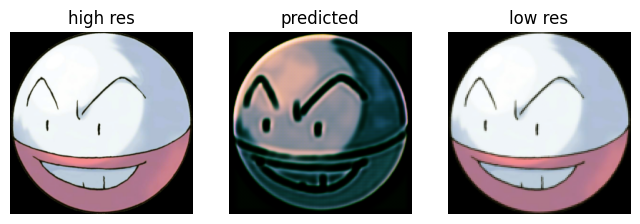

In [ ]:
def MSE_without_black(image1, image2):
    if image1.shape != image2.shape:
        raise ValueError("Images must have the same dimensions.")
    
    image1_f = image1.astype(float)
    image2_f = image2.astype(float)

    #Don't take into account black pixels
    
    filter = image1_f > 0.01                                           

    mse = np.mean((image1_f[filter] - image2_f[filter]) ** 2, dtype=np.float64)

    return mse

def PSNR_without_black(image1, image2):
    if image1.shape != image2.shape:
        raise ValueError("Images must have the same dimensions.")
    
    mse = MSE_without_black(image1, image2)
    if mse == 0:
        return float('inf')
    
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))

    return psnr

for _, (low_res, high_res) in enumerate(validation_loader):
    for idx in range(len(low_res)):
        if image_to_show != idx:
            continue
        
        # Get an image in train set
        image1 = high_res[idx].permute(1, 2, 0)
        print(image1.shape)

        # gen a fake image from the same image
        image2 = gen(low_res[idx].unsqueeze(0).to(device)).cpu().permute(0, 2, 3, 1)[0]
        print(image2.shape)

        # convert tensor image to numpy array
        image1 = image1.detach().numpy()
        image2 = image2.detach().numpy()

        from damage_image import Damager
        #image2 = Damager().add_salt_and_pepper_noise(image2, 0.01, 0.01)

        print(f"PSNR : {PSNR_without_black(image1, image2)}")

        # Plot the hight res, the low res and the fake image

        fig, axs = plt.subplots(1, 3, figsize=(8, 4))
        axs[0].set_axis_off()
        axs[0].imshow(image1)
        axs[0].set_title("high res")

        axs[1].set_axis_off()
        axs[1].imshow(image2)
        axs[1].set_title("predicted")

        axs[2].set_axis_off()
        axs[2].imshow(low_res[idx].permute(1, 2, 0))
        axs[2].set_title("low res")

        plt.show()